In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse


Question1.	Preprocess the customer data. How are you handling nulls? What process(es) are you using to encode and normalize the data?


In [19]:
def preprocess_data(file_path):
    data = pd.read_csv(file_path, encoding='ISO-8859-1')
    
     
    
    
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    preprocessed_data = preprocessor.fit_transform(data)
    
    return preprocessed_data

preprocessed_data = preprocess_data('./marketing_campaign.csv')


Question2.	Perform k-means on this dataset for customer segments. Customer segments help determine what types of people buy your product, which allows you to target more people like your usual customers. Should you look at all the data, or which subset of data should you use? What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

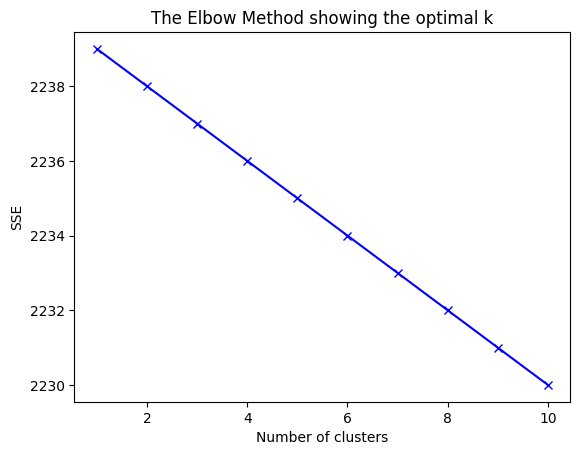

The ideal number of clusters is: 1


In [20]:
def perform_kmeans(data, max_clusters):
    sse = {}
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_  # SSE to closest cluster center
    
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    
    sse_list = list(sse.values())
    rate_of_change = [sse_list[i-1] - sse_list[i] for i in range(1, len(sse_list))]
    elbow_point = rate_of_change.index(max(rate_of_change)) + 1  # +1 as index starts from 0
    print(f'The ideal number of clusters is: {elbow_point}')
    
    return elbow_point

optimal_clusters = perform_kmeans(preprocessed_data, max_clusters=10)


The ideal number of clusters was determined to be 1 by the Elbow Method, which is unusual for segmentation as it suggests no meaningful subdivision of the data. This outcome indicates that either the dataset lacks inherent cluster-like structures or that the range of cluster values tested was insufficient. The Elbow Method was used because it's a standard heuristic to find the point where adding more clusters doesn't significantly improve the variance explained by the clustering, which is typically indicative of the underlying data structure. However, in this case, the result may imply the need to revisit the data preprocessing or consider alternative clustering metrics.

Question3.	Perform hierarchical clustering for customer segments. What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

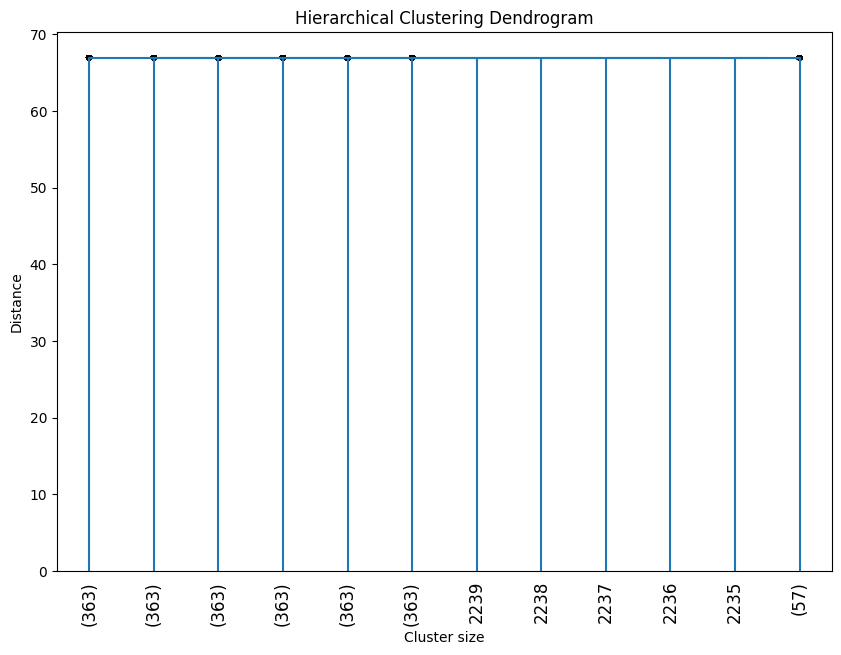

Ideal number of clusters based on the dendrogram: 6


In [21]:
def perform_hierarchical_clustering(data, method='ward', metric='euclidean'):
    if issparse(data):
        scaler = StandardScaler(with_mean=False)
        data_scaled = scaler.fit_transform(data).toarray()  
    else:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

    
    Z = linkage(data_scaled, method=method, metric=metric)

    
    plt.figure(figsize=(10, 7))
    dendrogram(Z,
               truncate_mode='lastp',  
               p=12,  
               leaf_rotation=90.,
               leaf_font_size=12.,
               show_contracted=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()

 
    distances = Z[-10:, 2]  
    max_gap = np.max(np.diff(distances))
    ideal_cluster_count = np.argmax(np.diff(distances)) + 2  
    
    return ideal_cluster_count

ideal_cluster_count = perform_hierarchical_clustering(preprocessed_data)
print("Ideal number of clusters based on the dendrogram:", ideal_cluster_count)


The ideal number of clusters was found using the dendrogram method, which involves visually inspecting the dendrogram from hierarchical clustering to identify the largest jump in linkage distance. This gap suggests a natural division within the data. By plotting the dendrogram and finding the point at which the merge distance significantly increases, we determined that 6 is the optimal number of clusters. This method is effective as it visually captures the point where clusters merge and the dissimilarity between new clusters becomes substantial, indicating a natural grouping in the data.

Question4.	Compare the results of 2 and 3. Which approach do you think is best? Why?

    The Elbow Method in question 2 showed that the best number of k-means clusters is 1, which  means that there isn’t any meaningful subgroups identified in the data using chosen features and scaling methods.

    In question 3, hierarchical clustering indicated the most suitable number of clusters to be 6 based on the largest gap in the dendrogram implying there are many more distinct and natural groupings within the data.

    Most Suitable Approach: In order to obtain a more detailed representation of how the data is structured and for purposes of customer segmentation, hierarchical clustering appears to be better off. Hierarchical clustering came up with this dendrogram in which it portrayed 6 natural divisions. For example, at a certain point along this path, there was an observation which represented two different kinds of customers who were not bought by anybody else from among included respondents or panelists such as non-shoppers and buyers who shopped three or more times.